# VQE with Qiskit Aer Primitives

This notebook demonstrates how to leverage the [Qiskit Aer Primitives](https://qiskit.github.io/qiskit-aer/apidocs/aer_primitives.html) to run both noiseless and noisy simulations locally. Qiskit Aer not only allows you to define your own custom noise model, but also to easily create a noise model based on the properties of a real quantum device. This notebook will show an example of the latter, to illustrate the general workflow of running algorithms with local noisy simulators.

For further information on the Qiskit Aer noise model, you can consult the [Qiskit Aer documentation](https://qiskit.github.io/qiskit-aer/apidocs/aer_noise.html), as well the tutorial for [building noise models](https://qiskit.github.io/qiskit-aer/tutorials/3_building_noise_models.html).

The algorithm of choice is once again VQE, where the task consists on finding the minimum (ground state) energy of a Hamiltonian. As shown in previous tutorials, VQE takes in a qubit operator as input. Here, you will take a set of Pauli operators that were originally computed by Qiskit Nature for the H2 molecule, using the [SparsePauliOp](https://quantum.cloud.ibm.com/docs/api/qiskit/qiskit.quantum_info.SparsePauliOp) class.

In [1]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

print(f"Number of qubits: {H2_op.num_qubits}")

Number of qubits: 2


As the above problem is still easily tractable classically, you can use `NumPyMinimumEigensolver` to compute a reference value to compare the results later.

In [2]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.85728


The following examples will all use the same ansatz and optimizer, defined as follows:

In [3]:
# define ansatz and optimizer
from qiskit.circuit.library import n_local
from qiskit_algorithms.optimizers import SPSA

iterations = 125
ansatz = n_local(2, rotation_blocks="ry", entanglement_blocks="cz")
spsa = SPSA(maxiter=iterations)

## Performance *without* backend noise

Let's first run the `VQE` on the default Aer simulator without adding noise from the backend. We'll still specify a target precision to simulate shot noise. This result should be relatively close to the reference value from the exact computation.

In [4]:
# define callback
# note: Re-run this cell to restart lists before training
counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [5]:
# define Aer Estimator for noiseless statevector simulation
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

seed = 170
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(options={"default_precision": 1e-2})

In [6]:
# instantiate and run VQE
from qiskit_algorithms import VQE

vqe = VQE(noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}")

VQE on Aer qasm simulator (no noise): -1.84078
Delta from reference energy value is 0.01649


You captured the energy values above during the convergence, so you can track the process in the graph below.

Text(0.5, 1.0, 'Convergence with no noise')

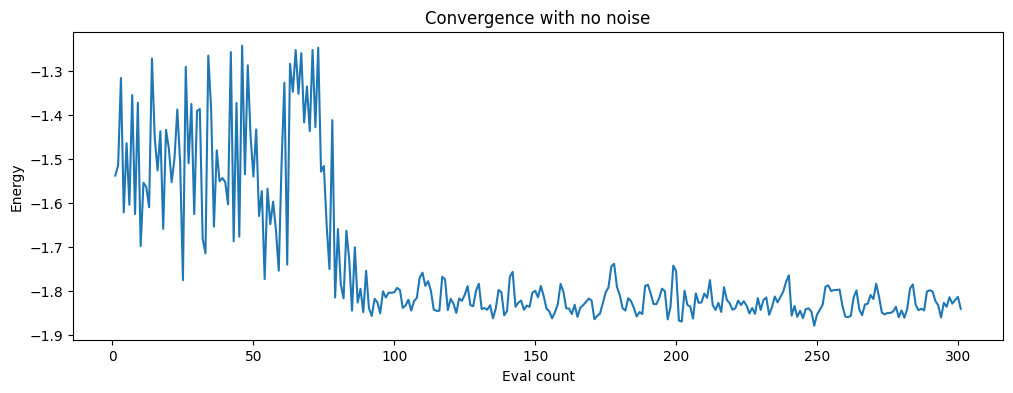

In [7]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

## Performance *with* backend noise

Now, let's add noise to our simulation. Here we create a fake device, using `GenericBackendV2`, which has a default noise model. As stated in the introduction, it is also possible to create custom noise models from scratch, but this task is beyond the scope of this notebook.

By default the fake device will have all to all coupling, so to make it more realistic, we will give it a coupling map (this map matches what the 5-qubit Vigo device had) Note: You can also use this coupling map as the entanglement map for the variational form if you choose to.

In [8]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2

coupling_map = [(0, 1), (1, 2), (2, 3), (3, 4)]
device = GenericBackendV2(num_qubits=5, coupling_map=coupling_map, seed=54)

noise_model = NoiseModel.from_backend(device)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'measure', 'cx', 'id', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('cx', (0, 1)), ('cx', (1, 2)), ('cx', (2, 3)), ('cx', (3, 4)), ('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


Once the noise model is defined, you can run `VQE` using an Aer `Estimator`, where you can pass the noise model to the underlying simulator using the `backend_options` dictionary. Please note that this simulation will take longer than the noiseless one.

In [9]:
noisy_estimator = AerEstimator(
    options={
        "default_precision": 1e-2,
        "backend_options": {
            "method": "density_matrix",
            "coupling_map": coupling_map,
            "noise_model": noise_model,
        },
    }
)

Instead of defining a new instance of the `VQE` class, you can now simply assign a new estimator to our previous `VQE` instance. As the callback method will be re-used, you will also need to re-start the `counts` and `values` variables to be able to plot the convergence graph later on.

In [10]:
# re-start callback variables
counts = []
values = []

In [11]:
vqe.estimator = noisy_estimator

result1 = vqe.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}")

VQE on Aer qasm simulator (with noise): -1.87908
Delta from reference energy value is -0.02181


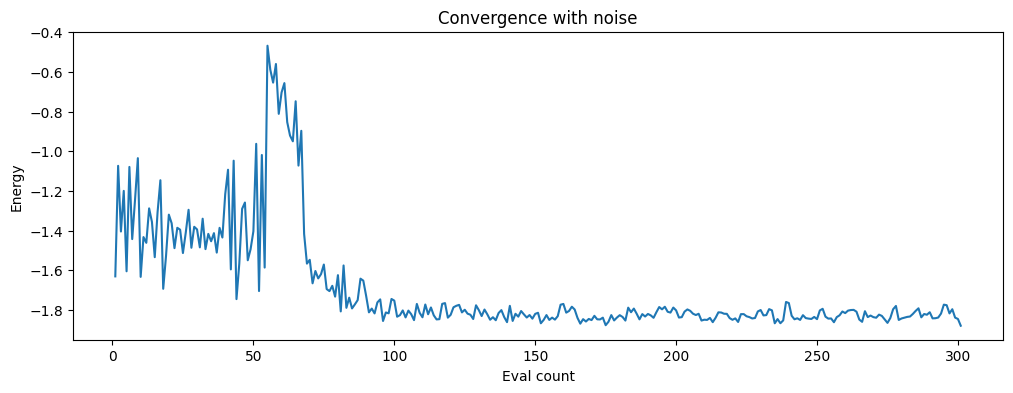

In [12]:
if counts or values:
    pylab.rcParams["figure.figsize"] = (12, 4)
    pylab.plot(counts, values)
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Convergence with noise")

## Summary


In this tutorial, you compared three calculations for the H2 molecule ground state.  First, you produced a reference value using a classical minimum eigensolver. Then, you proceeded to run `VQE` using the Qiskit Aer `Estimator` with a target precision of $10^{-2}$. Finally, you extracted a noise model from a backend and used it to define a new `Estimator` for noisy simulations. The results are:

In [13]:
print(f"Reference value: {ref_value:.5f}")
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}")

Reference value: -1.85728
VQE on Aer qasm simulator (no noise): -1.84078
VQE on Aer qasm simulator (with noise): -1.87908


You can notice that, while the noiseless simulation's result is closer to the exact reference value, there is still some difference. This is due to the sampling noise, introduced by limiting the target precision to $10^{-2}$, which in turn puts a limit on the number of shots the Estimator uses. A larger number of shots would decrease this sampling error and close the gap between these two values.

As for the noise introduced by real devices (or simulated noise models), it could be tackled through a wide variety of error mitigation techniques. The [Qiskit Runtime Primitives](https://quantum.cloud.ibm.com/docs/api/qiskit-ibm-runtime) have enabled error mitigation through the `resilience_level` option. This option is currently available for remote simulators and real backends accessed via the Runtime Primitives, you can consult [this documentation](https://quantum.cloud.ibm.com/docs/guides/configure-error-mitigation) for further information.

In [14]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright